# Libraries

In [1]:
# !pip install nbimporter # uncomment if library is not install


In [2]:
# Notebooks
import nbimporter
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Functions Notebook
from Functions import holisticsTrainTest, LOPOTrainTest, LOPO_cv
from Functions import comfPMV, ppv, selectModelParameters, trainTest_tunedModel, buildTrainRF, buildTrainKNN
from Functions import buildTrainSVM, buildTrainNB, buildMLP, getClfMetrics, saveModel

# Pandas, matplotlib, pickle, seaborn
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from collections import Counter


Importing Jupyter notebook from Functions.ipynb


# Import dataframes

In [3]:
# Run the pre-processing notebook first to make sure the pickle files exist

df_files = ['df_feature1', 'df_feature2', 'df_feature3', 'df_feature4', 'df_feature5']

df_feature1 = pd.read_pickle("df_feature1.pkl")
df_feature2 = pd.read_pickle("df_feature2.pkl")
df_feature3 = pd.read_pickle("df_feature3.pkl")
df_feature4 = pd.read_pickle("df_feature4.pkl")
df_feature5 = pd.read_pickle("df_feature5.pkl")


In [4]:
df_aux_65 = pd.read_csv("../datasets/TCS_65_participants_outsideData.csv", delimiter = ",")

# use_heuristics_participants = True

list_complete_participants = list(df_aux_65['Participant_No'].unique())

# if use_heuristics_participants:
#     list_complete_participants.append(10)
#     list_complete_participants.append(26)
#     list_complete_participants.append(28)
#     list_complete_participants.append(36)
#     list_complete_participants.append(37)
#     list_complete_participants.append(39)
#     list_complete_participants.append(47)
#     list_complete_participants.append(48)
#     list_complete_participants.append(53)


num_complete_participants = len(list_complete_participants)
print("Complete Participants: {}".format(list_complete_participants))
print("Total number of complete participants: {}".format(num_complete_participants))

Complete Participants: [1, 2, 4, 5, 6, 7, 8, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34, 35, 40, 41, 42, 43, 44, 45, 46, 49, 50, 51, 52, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Total number of complete participants: 65



# Prepare train and test split

We will divide the datasets into 80% for training and 20% for testing. With the training datset, 10fold cross validation will be usd to determined the hyperparameteres and validation will be used with the unseen test set. for the holistic approach, we will use the all votes without considering the participant number

In [5]:

df_feature1_train, df_feature1_test, df_feature1_train_binary, df_feature1_test_binary = holisticsTrainTest(df_feature1, 
                                                                                                            list_complete_participants)


df_feature2_train, df_feature2_test, df_feature2_train_binary, df_feature2_test_binary  = holisticsTrainTest(df_feature2, 
                                                                                                             list_complete_participants)

df_feature3_train, df_feature3_test, df_feature3_train_binary, df_feature3_test_binary = holisticsTrainTest(df_feature3,
                                                                                                           list_complete_participants)

df_feature4_train, df_feature4_test, df_feature4_train_binary, df_feature4_test_binary = holisticsTrainTest(df_feature4,
                                                                                                           list_complete_participants)

df_feature5_train, df_feature5_test, df_feature5_train_binary, df_feature5_test_binary = holisticsTrainTest(df_feature5,
                                                                                                            list_complete_participants)

print("Total number of instances: {}".format(df_feature1.shape[0]))

print("Number of training instances: {}".format(df_feature1_train.shape[0]))
print("Number of testing (validation) instances: {}".format(df_feature1_test.shape[0]))

13
Testing on participants:
[ 4 40 41 43 57 58 61 64 68 70 71 73 80]
13
Testing on participants:
[ 4 40 41 43 57 58 61 64 68 70 71 73 80]
13
Testing on participants:
[ 4 40 41 43 57 58 61 64 68 70 71 73 80]
13
Testing on participants:
[ 4 40 41 43 57 58 61 64 68 70 71 73 80]
13
Testing on participants:
[ 4 40 41 43 57 58 61 64 68 70 71 73 80]
Total number of instances: 2067
Number of training instances: 1713
Number of testing (validation) instances: 354


# PMV

In [6]:
"""
ta, air temperature (C)
tr, mean radiant temperature (C)
vel, relative air velocity (m/s)
rh, relative humidity (%) Used only this way to input humidity level
met, metabolic rate (met)
clo, clothing (clo)
wme, external work, normally around 0 (met)
"""

# technically any df_featureX_test can be used since the only difference between them is the amount of columns they have
ta = (df_feature1_test['Temperature (Fahrenheit)']  - 32) * 5 / 9
ta = ta.reset_index(drop=True)
tr = 25 # standard
vel = 0.2 # standard
rh = 0.60 # standard
met = 1.1 # standard
clo = df_feature1_test['ClothingInsulation'] # standard is 0.8
clo = clo.reset_index(drop=True)
wme = 0

holistic_pmv_list = []

for i in range(df_feature1_test.shape[0]):
    pmv, ppd = comfPMV(ta[i], tr, vel, rh, met, clo[i], wme)
    holistic_pmv_list.append(round(pmv,0))
    
# print(holistic_pmv_list) # TODO: debugging
holistic_pmv_array = np.array(holistic_pmv_list)
# clip to -2,+2
holistic_pmv_array = np.clip(holistic_pmv_array, a_min = -2, a_max = 2) 

# remap for binary pmv
holistic_pmv_array_binary = pd.DataFrame(holistic_pmv_list)
holistic_pmv_array_binary = holistic_pmv_array_binary.iloc[:,0].map(lambda x: 1 if x != 0 else 0)
holistic_pmv_array_binary = np.array(holistic_pmv_array_binary)

pmv_holistic_1_acc = getClfMetrics(df_feature1_test['Discrete Thermal Comfort_TA'], holistic_pmv_array)
pmv_holistic_1_acc_binary = getClfMetrics(df_feature1_test_binary['Discrete Thermal Comfort_TA'], 
                                          holistic_pmv_array_binary)

pmv_holistic_2_acc = getClfMetrics(df_feature2_test['Discrete Thermal Comfort_TA'], holistic_pmv_array)
pmv_holistic_2_acc_binary = getClfMetrics(df_feature2_test_binary['Discrete Thermal Comfort_TA'], 
                                          holistic_pmv_array_binary)

# no measured clo value
clo = 0.8
holistic_pmv_list = []
# recompute of pmv
for i in range(df_feature1_test.shape[0]):
    pmv, ppd = comfPMV(ta[i], tr, vel, rh, met, clo, wme)
    holistic_pmv_list.append(round(pmv,0))

holistic_pmv_array_noclo = np.array(holistic_pmv_list)
# clip to -2,+2
holistic_pmv_array_noclo = np.clip(holistic_pmv_array_noclo, a_min = -2, a_max = 2) 

# remap for binary pmv
holistic_pmv_array_noclo_binary = pd.DataFrame(holistic_pmv_array_noclo)
holistic_pmv_array_noclo_binary = holistic_pmv_array_noclo_binary.iloc[:,0].map(lambda x: 1 if x != 0 else 0)
holistic_pmv_array_noclo_binary = np.array(holistic_pmv_array_noclo_binary)

pmv_holistic_3_acc = getClfMetrics(df_feature3_test['Discrete Thermal Comfort_TA'], holistic_pmv_array_noclo)
pmv_holistic_3_acc_binary = getClfMetrics(df_feature3_test_binary['Discrete Thermal Comfort_TA'], 
                                          holistic_pmv_array_noclo_binary)

pmv_holistic_4_acc = getClfMetrics(df_feature4_test['Discrete Thermal Comfort_TA'], holistic_pmv_array_noclo)
pmv_holistic_4_acc_binary = getClfMetrics(df_feature4_test_binary['Discrete Thermal Comfort_TA'], 
                                          holistic_pmv_array_noclo_binary)

pmv_holistic_5_acc = getClfMetrics(df_feature5_test['Discrete Thermal Comfort_TA'], holistic_pmv_array_noclo)
pmv_holistic_5_acc_binary = getClfMetrics(df_feature5_test_binary['Discrete Thermal Comfort_TA'], 
                                          holistic_pmv_array_noclo_binary)




Accuracy (f1 micro) on test set:  0.3248587570621469
F1 micro on test set:  0.3248587570621469
F1 macro on test set:  0.1955856338783168

Confusion Matrix: 
[[22  3  2  0  0]
 [59 32  8  0  0]
 [48 93 61  0  0]
 [ 0 15  7  0  0]
 [ 0  4  0  0  0]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.17      0.81      0.28        27
          -1       0.22      0.32      0.26        99
           0       0.78      0.30      0.44       202
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00         4

   micro avg       0.32      0.32      0.32       354
   macro avg       0.23      0.29      0.20       354
weighted avg       0.52      0.32      0.34       354


Accuracy (f1 micro) on test set:  0.5536723163841808
F1 micro on test set:  0.5536723163841808
F1 macro on test set:  0.5332777036048064

Confusion Matrix: 
[[ 61 141]
 [ 17 135]]

Classification Metrics: 
              precision    re

/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', av

# PPV

ppv(x) = pmv(x) + personal(x)

personal(x) = a'.x + b

a={a_temp, a_radiant, a_velocity, a_humidity, a_metabolic, a_clothing}

In [ ]:
ta_1 = (df_feature1_test['Temperature (Fahrenheit)']  - 32) * 5 / 9 
ta_1 = ta_1.reset_index(drop=True)

ta_2 = (df_feature2_test['Temperature (Fahrenheit)']  - 32) * 5 / 9 
ta_2 = ta_2.reset_index(drop=True)

ta_3 = (df_feature3_test['Temperature (Fahrenheit)']  - 32) * 5 / 9 
ta_3 = ta_3.reset_index(drop=True)

ta_4 = (df_feature4_test['Temperature (Fahrenheit)']  - 32) * 5 / 9 
ta_4 = ta_4.reset_index(drop=True)

ta_5 = (df_feature5_test['Temperature (Fahrenheit)']  - 32) * 5 / 9 
ta_5 = ta_5.reset_index(drop=True)

tr = 25 # standard
vel = 0.2 # standard
rh = 0.60 # standard
met = 1.1 # standard
wme = 0

clo_1 = df_feature1_test['ClothingInsulation'] # standard is 0.8
clo_1 = clo_1.reset_index(drop=True)

clo_2 = df_feature2_test['ClothingInsulation'] # standard is 0.8
clo_2 = clo_2.reset_index(drop=True)

clo_3 = 0.8 # standard is 0.8

clo_4 = 0.8 # standard is 0.8

clo_5 = 0.8 # standard is 0.8


In [ ]:
ppv_1_acc = ppv(holistic_pmv_array, df_feature1_train, df_feature1_test, ta_1, tr, vel, rh, met, clo_1)
ppv_1_acc_binary = ppv(holistic_pmv_array_binary, df_feature1_train_binary, df_feature1_test_binary, ta_1, tr, vel, rh, 
                            met, clo_1, binary=True)

ppv_2_acc = ppv(holistic_pmv_array, df_feature2_train, df_feature1_test, ta_2, tr, vel, rh, met, clo_2)
ppv_2_acc_binary = ppv(holistic_pmv_array_binary, df_feature2_train_binary, df_feature1_test_binary, ta_2, tr, vel, rh, 
                            met, clo_2, binary=True)

ppv_3_acc = ppv(holistic_pmv_array_noclo, df_feature3_train, df_feature1_test, ta_3, tr, vel, rh, met, clo_3, no_clo=True)
ppv_3_acc_binary = ppv(holistic_pmv_array_noclo_binary, df_feature3_train_binary, df_feature1_test_binary, ta_3, tr, vel, rh,
                            met, clo_3, binary=True, no_clo=True)

ppv_4_acc = ppv(holistic_pmv_array_noclo, df_feature4_train, df_feature1_test, ta_4, tr, vel, rh, met, clo_4, no_clo=True)
ppv_4_acc_binary = ppv(holistic_pmv_array_noclo_binary, df_feature4_train_binary, df_feature1_test_binary, ta_4, tr, vel, rh, 
                            met, clo_4, binary=True, no_clo=True)

ppv_5_acc = ppv(holistic_pmv_array_noclo, df_feature5_train, df_feature1_test, ta_5, tr, vel, rh, met, clo_5, no_clo=True)
ppv_5_acc_binary = ppv(holistic_pmv_array_noclo_binary, df_feature5_train_binary, df_feature1_test_binary, ta_5, tr, vel, rh, 
                            met, clo_5, binary=True, no_clo=True)



Accuracy (f1 micro) on test set:  0.2909604519774011
F1 micro on test set:  0.2909604519774011
F1 macro on test set:  0.24457681824394467

Confusion Matrix: 
[[27  0  0  0  0]
 [91  8  0  0  0]
 [48 93 61  0  0]
 [ 0  0 15  7  0]
 [ 0  0  0  4  0]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.16      1.00      0.28        27
          -1       0.08      0.08      0.08        99
           0       0.80      0.30      0.44       202
           1       0.64      0.32      0.42        22
           2       0.00      0.00      0.00         4

   micro avg       0.29      0.29      0.29       354
   macro avg       0.34      0.34      0.24       354
weighted avg       0.53      0.29      0.32       354


Accuracy (f1 micro) on test set:  0.6016949152542372
F1 micro on test set:  0.6016949152542372
F1 macro on test set:  0.573512197205964

Confusion Matrix: 
[[ 61 141]
 [  0 152]]

Classification Metrics: 
              precision    re

/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', av

              precision    recall  f1-score   support

          -2       0.16      1.00      0.28        27
          -1       0.08      0.08      0.08        99
           0       0.80      0.30      0.44       202
           1       0.64      0.32      0.42        22
           2       0.00      0.00      0.00         4

   micro avg       0.29      0.29      0.29       354
   macro avg       0.34      0.34      0.24       354
weighted avg       0.53      0.29      0.32       354


Accuracy (f1 micro) on test set:  0.6016949152542372
F1 micro on test set:  0.6016949152542372
F1 macro on test set:  0.573512197205964

Confusion Matrix: 
[[ 61 141]
 [  0 152]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       1.00      0.30      0.46       202
           1       0.52      1.00      0.68       152

   micro avg       0.60      0.60      0.60       354
   macro avg       0.76      0.65      0.57       354
weighted avg       0.79      0.60

/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Majority-Class Model

In [ ]:
# majority class is the comfort label 0
base_model_pred = np.zeros(int(len(df_feature1_test)))

# get the label from the test dataframe
y_test = np.array(df_feature1_test['Discrete Thermal Comfort_TA'])

majority_class_acc = getClfMetrics(y_test, base_model_pred)

# majority class binary
base_model_pred_binary = np.zeros(int(len(df_feature1_test_binary)))

# get the label from the test dataframe
y_test = np.array(df_feature1_test_binary['Discrete Thermal Comfort_TA'])

majority_class_acc_binary = getClfMetrics(y_test, base_model_pred_binary)



Accuracy (f1 micro) on test set:  0.5706214689265536
F1 micro on test set:  0.5706214689265536
F1 macro on test set:  0.14532374100719422

Confusion Matrix: 
[[  0   0  27   0   0]
 [  0   0  99   0   0]
 [  0   0 202   0   0]
 [  0   0  22   0   0]
 [  0   0   4   0   0]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        27
          -1       0.00      0.00      0.00        99
           0       0.57      1.00      0.73       202
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00         4

   micro avg       0.57      0.57      0.57       354
   macro avg       0.11      0.20      0.15       354
weighted avg       0.33      0.57      0.41       354


Accuracy (f1 micro) on test set:  0.5706214689265536
F1 micro on test set:  0.5706214689265536
F1 macro on test set:  0.3633093525179856

Confusion Matrix: 
[[202   0]
 [152   0]]

Classification Metrics: 
   

/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', av

# RF

Features: ['Temperature (Fahrenheit)' 'SkinTemperature' 'ClothingInsulation'
 'Height(cm)' 'Shoulder Circumference(cm)' 'Weight(lbs)' 'Gender'
 'Temperature_outside' 'Humidity_outside']
Number of folds: 10


/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 1000}
Finding optimal tree depth


No handles with labels found to put in legend.


The optimal depth is:  13 

Expected accuracy (f1 micro) based on Cross-Validation:  0.738814569150666 



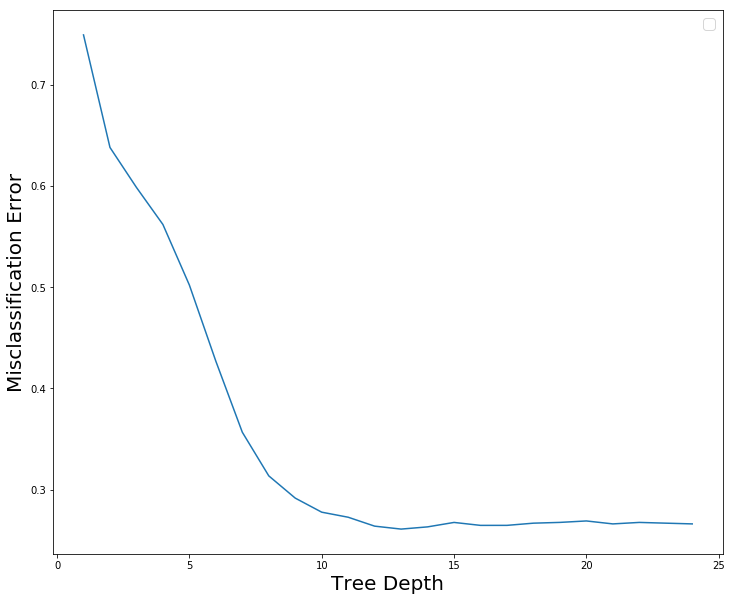

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=13, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set:  0.7201166180758017
F1 micro on test set:  0.7201166180758017
F1 macro on test set:  0.5757540078362098

Confusion Matrix: 
[[ 23  14   1   0   0]
 [ 13  34  23   0   1]
 [  1  15 168   6   0]
 [  0   0  14  20   1]
 [  0   0   2   5   2]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.62      0.61      0.61        38
          -1       0.54      0.48      0.51        71
           0       0.81      0.88      0.84       190
           1       0.65      0.57      0.61 

No handles with labels found to put in legend.


The optimal depth is:  16 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8116788321167883 



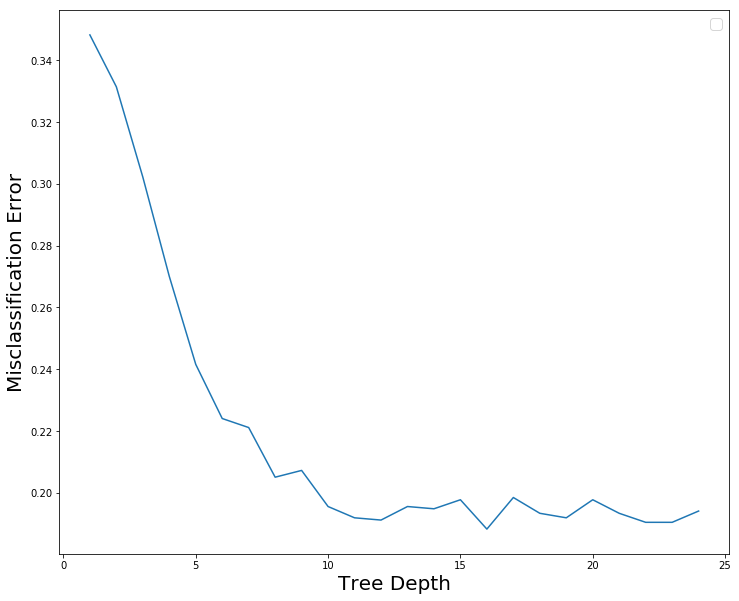

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=16, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set:  0.7959183673469388
F1 micro on test set:  0.7959183673469388
F1 macro on test set:  0.7929601269315674

Confusion Matrix: 
[[157  33]
 [ 37 116]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       190
           1       0.78      0.76      0.77       153

   micro avg       0.80      0.80      0.80       343
   macro avg       0.79      0.79      0.79       343
weighted avg       0.80      0.80      0.80       343



In [ ]:
acc_rf_1_train, rf_optimal_1 = buildTrainRF(df_feature1_train)
acc_rf_1_train_binary, rf_optimal_1_binary = buildTrainRF(df_feature1_train_binary)

saveModel('rf_optimal_1.pkl', rf_optimal_1)
saveModel('rf_optimal_1_binary.pkl', rf_optimal_1_binary)


In [ ]:
# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_rf_1, _ = trainTest_tunedModel(df_feature1_train, df_feature1_test, rf_optimal_1)
acc_holistic_rf_1_binary, _ = trainTest_tunedModel(df_feature1_train_binary, df_feature1_test_binary, 
                                                rf_optimal_1_binary)



Accuracy (f1 micro) on test set:  0.596045197740113
F1 micro on test set:  0.596045197740113
F1 macro on test set:  0.32627928934280165

Confusion Matrix: 
[[  0   7  20   0   0]
 [  3  38  58   0   0]
 [  7  22 162  11   0]
 [  0   0  11  11   0]
 [  0   0   0   4   0]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        27
          -1       0.57      0.38      0.46        99
           0       0.65      0.80      0.72       202
           1       0.42      0.50      0.46        22
           2       0.00      0.00      0.00         4

   micro avg       0.60      0.60      0.60       354
   macro avg       0.33      0.34      0.33       354
weighted avg       0.55      0.60      0.56       354



/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', av


Accuracy (f1 micro) on test set:  0.6610169491525424
F1 micro on test set:  0.6610169491525424
F1 macro on test set:  0.6472229604039331

Confusion Matrix: 
[[152  50]
 [ 70  82]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.68      0.75      0.72       202
           1       0.62      0.54      0.58       152

   micro avg       0.66      0.66      0.66       354
   macro avg       0.65      0.65      0.65       354
weighted avg       0.66      0.66      0.66       354



Features: ['Temperature (Fahrenheit)' 'SkinTemperature' 'ClothingInsulation'
 'Gender' 'Temperature_outside' 'Humidity_outside']
Number of folds: 10


/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 1000}
Finding optimal tree depth


No handles with labels found to put in legend.


The optimal depth is:  12 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7293712901849286 



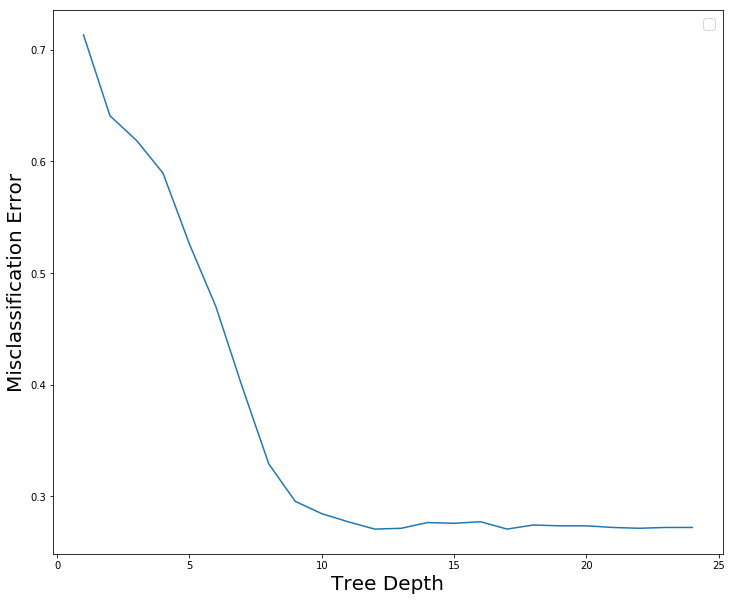

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set:  0.7142857142857143
F1 micro on test set:  0.7142857142857143
F1 macro on test set:  0.5624449182658138

Confusion Matrix: 
[[ 20  16   2   0   0]
 [ 13  34  24   0   0]
 [  1  13 171   5   0]
 [  0   0  16  18   1]
 [  0   0   2   5   2]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.59      0.53      0.56        38
          -1       0.54      0.48      0.51        71
           0       0.80      0.90      0.84       190
           1       0.64      0.51      0.57        

No handles with labels found to put in legend.


The optimal depth is:  14 

Expected accuracy (f1 micro) based on Cross-Validation:  0.808029197080292 



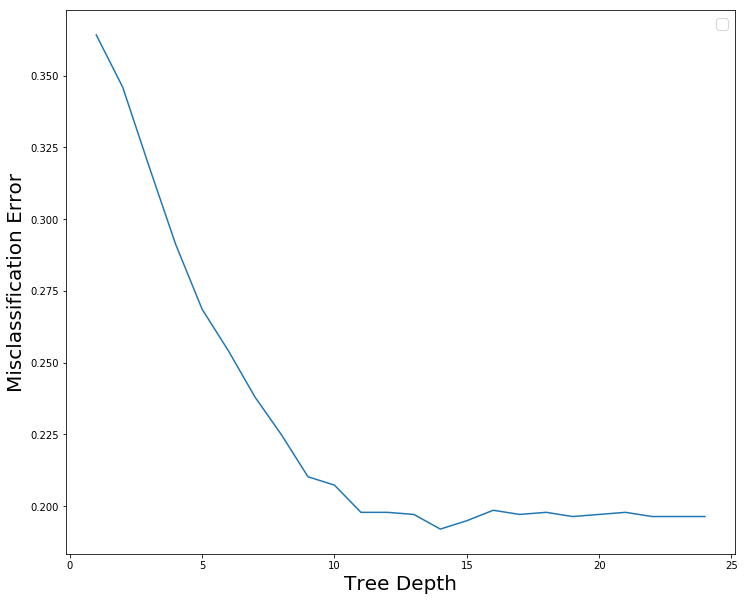

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=14, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set:  0.8104956268221575
F1 micro on test set:  0.8104956268221575
F1 macro on test set:  0.8081407856804785

Confusion Matrix: 
[[158  32]
 [ 33 120]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       190
           1       0.79      0.78      0.79       153

   micro avg       0.81      0.81      0.81       343
   macro avg       0.81      0.81      0.81       343
weighted avg       0.81      0.81      0.81       343



In [ ]:
acc_rf_2_train, rf_optimal_2 = buildTrainRF(df_feature2_train)
acc_rf_2_train_binary, rf_optimal_2_binary = buildTrainRF(df_feature2_train_binary)

saveModel('rf_optimal_2.pkl', rf_optimal_2)
saveModel('rf_optimal_2_binary.pkl', rf_optimal_2_binary)


In [ ]:
# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_rf_2, _ = trainTest_tunedModel(df_feature2_train, df_feature2_test, rf_optimal_2)
acc_holistic_rf_2_binary, _ = trainTest_tunedModel(df_feature2_train_binary, df_feature2_test_binary, rf_optimal_2)



Accuracy (f1 micro) on test set:  0.519774011299435
F1 micro on test set:  0.519774011299435
F1 macro on test set:  0.3224223933972561

Confusion Matrix: 
[[  5   7  15   0   0]
 [ 16  37  46   0   0]
 [ 11  39 134  11   7]
 [  0   0  14   8   0]
 [  0   0   4   0   0]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.16      0.19      0.17        27
          -1       0.45      0.37      0.41        99
           0       0.63      0.66      0.65       202
           1       0.42      0.36      0.39        22
           2       0.00      0.00      0.00         4

   micro avg       0.52      0.52      0.52       354
   macro avg       0.33      0.32      0.32       354
weighted avg       0.52      0.52      0.52       354


Accuracy (f1 micro) on test set:  0.6412429378531074
F1 micro on test set:  0.6412429378531074
F1 macro on test set:  0.6372804505151396

Confusion Matrix: 
[[132  70]
 [ 57  95]]

Classification Metrics: 
      

In [ ]:
acc_rf_3_train, rf_optimal_3 = buildTrainRF(df_feature3_train)
acc_rf_3_train_binary, rf_optimal_3_binary = buildTrainRF(df_feature3_train_binary)

saveModel('rf_optimal_3.pkl', rf_optimal_3)
saveModel('rf_optimal_3_binary.pkl', rf_optimal_3_binary)


Features: ['Temperature (Fahrenheit)' 'Height(cm)' 'Shoulder Circumference(cm)'
 'Weight(lbs)' 'Temperature_outside' 'Humidity_outside']
Number of folds: 10


/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 1000}
Finding optimal tree depth


In [ ]:
# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_rf_3, _ = trainTest_tunedModel(df_feature3_train, df_feature3_test, rf_optimal_3)
acc_holistic_rf_3_binary, _ = trainTest_tunedModel(df_feature3_train_binary, df_feature3_test_binary, 
                                                rf_optimal_3_binary)


In [ ]:
acc_rf_4_train, rf_optimal_4 = buildTrainRF(df_feature4_train)
acc_rf_4_train_binary, rf_optimal_4_binary = buildTrainRF(df_feature4_train_binary)

saveModel('rf_optimal_4.pkl', rf_optimal_4)
saveModel('rf_optimal_4_binary.pkl', rf_optimal_4_binary)


In [ ]:
# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_rf_4, _ = trainTest_tunedModel(df_feature4_train, df_feature4_test, rf_optimal_4)
acc_holistic_rf_4_binary, _ = trainTest_tunedModel(df_feature4_train_binary, df_feature4_test_binary, 
                                                rf_optimal_4_binary)


In [ ]:
acc_rf_5_train, rf_optimal_5 = buildTrainRF(df_feature5_train)
acc_rf_5_train_binary, rf_optimal_5_binary = buildTrainRF(df_feature5_train_binary)

saveModel('rf_optimal_5.pkl', rf_optimal_5)
saveModel('rf_optimal_5_binary.pkl', rf_optimal_5_binary)


In [ ]:
# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_rf_5, _ = trainTest_tunedModel(df_feature5_train, df_feature5_test, rf_optimal_5)
acc_holistic_rf_5_binary, _ = trainTest_tunedModel(df_feature5_train_binary, df_feature5_test_binary,
                                                rf_optimal_5_binary)


# KNN

In [ ]:
acc_knn_1_train, knn_optimal_1 = buildTrainKNN(df_feature1_train)
acc_knn_1_train_binary, knn_optimal_1_binary = buildTrainKNN(df_feature1_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_knn_1, _ = trainTest_tunedModel(df_feature1_train, df_feature1_test, knn_optimal_1)
acc_holistic_knn_1_binary, _ = trainTest_tunedModel(df_feature1_train_binary, df_feature1_test_binary,
                                                 knn_optimal_1_binary)
saveModel('knn_optimal_1.pkl', knn_optimal_1)
saveModel('knn_optimal_1_binary.pkl', knn_optimal_1_binary)


In [ ]:
acc_knn_2_train, knn_optimal_2 = buildTrainKNN(df_feature2_train)
acc_knn_2_train_binary, knn_optimal_2_binary = buildTrainKNN(df_feature2_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_knn_2, _ = trainTest_tunedModel(df_feature2_train, df_feature2_test, knn_optimal_2)
acc_holistic_knn_2_binary, _ = trainTest_tunedModel(df_feature2_train_binary, df_feature2_test_binary,
                                                 knn_optimal_2_binary)

saveModel('knn_optimal_2.pkl', knn_optimal_2)
saveModel('knn_optimal_2_binary.pkl', knn_optimal_2_binary)


In [ ]:
acc_knn_3_train, knn_optimal_3 = buildTrainKNN(df_feature3_train)
acc_knn_3_train_binary, knn_optimal_3_binary = buildTrainKNN(df_feature3_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_knn_3, _ = trainTest_tunedModel(df_feature3_train, df_feature3_test, knn_optimal_3)
acc_holistic_knn_3_binary, _ = trainTest_tunedModel(df_feature3_train_binary, df_feature3_test_binary,
                                                 knn_optimal_3_binary)
saveModel('knn_optimal_3.pkl', knn_optimal_3)
saveModel('knn_optimal_3_binary.pkl', knn_optimal_3_binary)


In [ ]:
acc_knn_4_train, knn_optimal_4 = buildTrainKNN(df_feature4_train)
acc_knn_4_train_binary, knn_optimal_4_binary = buildTrainKNN(df_feature4_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_knn_4, _ = trainTest_tunedModel(df_feature4_train, df_feature4_test, knn_optimal_4)
acc_holistic_knn_4_binary, _ = trainTest_tunedModel(df_feature4_train_binary, df_feature4_test_binary,
                                                 knn_optimal_4_binary)

saveModel('knn_optimal_4.pkl', knn_optimal_4)
saveModel('knn_optimal_4_binary.pkl', knn_optimal_4_binary)


In [ ]:
acc_knn_5_train, knn_optimal_5 = buildTrainKNN(df_feature5_train)
acc_knn_5_train_binary, knn_optimal_5_binary = buildTrainKNN(df_feature5_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_knn_5, _ = trainTest_tunedModel(df_feature5_train, df_feature5_test, knn_optimal_5)
acc_holistic_knn_5_binary, _ = trainTest_tunedModel(df_feature5_train_binary, df_feature5_test_binary,
                                                 knn_optimal_5_binary)
saveModel('knn_optimal_5.pkl', knn_optimal_5)
saveModel('knn_optimal_5_binary.pkl', knn_optimal_5_binary)


# SVM 

In [ ]:
acc_svm_1_train, svm_optimal_1 = buildTrainSVM(df_feature1_train)
acc_svm_1_train_binary, svm_optimal_1_binary = buildTrainSVM(df_feature1_train_binary)


# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_svm_1, _ = trainTest_tunedModel(df_feature1_train, df_feature1_test, svm_optimal_1)
acc_holistic_svm_1_binary, _ = trainTest_tunedModel(df_feature1_train_binary, df_feature1_test_binary,
                                                 svm_optimal_1_binary)
saveModel('svm_optimal_1.pkl', svm_optimal_1)
saveModel('svm_optimal_1_binary.pkl', svm_optimal_1_binary)


In [ ]:
acc_svm_2_train, svm_optimal_2 = buildTrainSVM(df_feature2_train)
acc_svm_2_train_binary, svm_optimal_2_binary = buildTrainSVM(df_feature2_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_svm_2, _ = trainTest_tunedModel(df_feature2_train, df_feature2_test, svm_optimal_2)
acc_holistic_svm_2_binary, _ = trainTest_tunedModel(df_feature2_train_binary, df_feature2_test_binary,
                                                 svm_optimal_2_binary)
saveModel('svm_optimal_2.pkl', svm_optimal_2)
saveModel('svm_optimal_2_binary.pkl', svm_optimal_2_binary)


In [ ]:
acc_svm_3_train, svm_optimal_3 = buildTrainSVM(df_feature3_train)
acc_svm_3_train_binary, svm_optimal_3_binary = buildTrainSVM(df_feature3_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_svm_3, _ = trainTest_tunedModel(df_feature3_train, df_feature3_test, svm_optimal_3)
acc_holistic_svm_3_binary, _ = trainTest_tunedModel(df_feature3_train_binary, df_feature3_test_binary,
                                                 svm_optimal_3_binary)
saveModel('svm_optimal_3.pkl', svm_optimal_3)
saveModel('svm_optimal_3_binary.pkl', svm_optimal_3_binary)


In [ ]:
acc_svm_4_train, svm_optimal_4 = buildTrainSVM(df_feature4_train)
acc_svm_4_train_binary, svm_optimal_4_binary = buildTrainSVM(df_feature4_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_svm_4, _ = trainTest_tunedModel(df_feature4_train, df_feature4_test, svm_optimal_4)
acc_holistic_svm_4_binary, _ = trainTest_tunedModel(df_feature4_train_binary, df_feature4_test_binary,
                                                 svm_optimal_4_binary)
saveModel('svm_optimal_4.pkl', svm_optimal_4)
saveModel('svm_optimal_4_binary.pkl', svm_optimal_4_binary)


In [ ]:
acc_svm_5_train, svm_optimal_5 = buildTrainSVM(df_feature5_train)
acc_svm_5_train_binary, svm_optimal_5_binary = buildTrainSVM(df_feature5_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_svm_5, _ = trainTest_tunedModel(df_feature5_train, df_feature5_test, svm_optimal_5)
acc_holistic_svm_5_binary, _ = trainTest_tunedModel(df_feature5_train_binary, df_feature5_test_binary,
                                                 svm_optimal_5_binary)
saveModel('svm_optimal_5.pkl', svm_optimal_5)
saveModel('svm_optimal_5_binary.pkl', svm_optimal_5_binary)


# NB

In [ ]:
acc_nb_1_train, nb_optimal_1 = buildTrainNB(df_feature1_train)
acc_nb_1_train_binary, nb_optimal_1_binary = buildTrainNB(df_feature1_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_nb_1, _ = trainTest_tunedModel(df_feature1_train, df_feature1_test, nb_optimal_1)
acc_holistic_nb_1_binary, _ = trainTest_tunedModel(df_feature1_train_binary, df_feature1_test_binary,
                                                nb_optimal_1_binary)
saveModel('nb_optimal_1.pkl', nb_optimal_1)
saveModel('nb_optimal_1_binary.pkl', nb_optimal_1_binary)


In [ ]:
acc_nb_2_train, nb_optimal_2 = buildTrainNB(df_feature1_train)
acc_nb_2_train_binary, nb_optimal_2_binary = buildTrainNB(df_feature1_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_nb_2, _ = trainTest_tunedModel(df_feature1_train, df_feature1_test, nb_optimal_2)
acc_holistic_nb_2_binary, _ = trainTest_tunedModel(df_feature1_train_binary, df_feature1_test_binary,
                                                nb_optimal_2_binary)
saveModel('nb_optimal_2.pkl', nb_optimal_2)
saveModel('nb_optimal_2_binary.pkl', nb_optimal_2_binary)


In [ ]:
acc_nb_3_train, nb_optimal_3 = buildTrainNB(df_feature1_train)
acc_nb_3_train_binary, nb_optimal_3_binary = buildTrainNB(df_feature1_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_nb_3, _ = trainTest_tunedModel(df_feature1_train, df_feature1_test, nb_optimal_3)
acc_holistic_nb_3_binary, _ = trainTest_tunedModel(df_feature1_train_binary, df_feature1_test,
                                                nb_optimal_3_binary)
saveModel('nb_optimal_3.pkl', nb_optimal_3)
saveModel('nb_optimal_3_binary.pkl', nb_optimal_3_binary)


In [ ]:
acc_nb_4_train, nb_optimal_4 = buildTrainNB(df_feature1_train)
acc_nb_4_train_binary, nb_optimal_4_binary = buildTrainNB(df_feature1_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_nb_4, _ = trainTest_tunedModel(df_feature1_train, df_feature1_test, nb_optimal_4)
acc_holistic_nb_4_binary, _ = trainTest_tunedModel(df_feature1_train_binary, df_feature1_test_binary,
                                                nb_optimal_4_binary)
saveModel('nb_optimal_4.pkl', nb_optimal_4)
saveModel('nb_optimal_4_binary.pkl', nb_optimal_4_binary)



In [ ]:
acc_nb_5_train, nb_optimal_5 = buildTrainNB(df_feature1_train)
acc_nb_5_train_binary, nb_optimal_5_binary = buildTrainNB(df_feature1_train_binary)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_nb_5, _ = trainTest_tunedModel(df_feature1_train, df_feature1_test, nb_optimal_5)
acc_holistic_nb_5_binary, _ = trainTest_tunedModel(df_feature1_train_binary, df_feature1_test_binary,
                                                nb_optimal_5_binary)
saveModel('nb_optimal_5.pkl', nb_optimal_5)
saveModel('nb_optimal_5_binary.pkl', nb_optimal_5_binary)


# MLP

In [ ]:
acc_mlp_1_train, mlp_1 = buildMLP(df_feature1_train)
acc_mlp_1_train_binary, mlp_1_binary = buildMLP(df_feature1_train_binary, binary=True)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_mlp_1, _ = trainTest_tunedModel(df_feature1_train, df_feature1_test, mlp_1, mlp_tuned=True)
acc_holistic_mlp_1_binary, _ = trainTest_tunedModel(df_feature1_train_binary, df_feature1_test_binary,
                                                mlp_1_binary, mlp_tuned=True, binary_mlp=True)
print(acc_holistic_mlp_1)
print(acc_holistic_mlp_1_binary)

saveModel('mlp_1.pkl', mlp_1)
saveModel('mlp_1_binary.pkl', mlp_1_binary)


In [ ]:
acc_mlp_2_train, mlp_2 = buildMLP(df_feature2_train)
acc_mlp_2_train_binary, mlp_2_binary = buildMLP(df_feature2_train_binary, binary=True)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_mlp_2, _ = trainTest_tunedModel(df_feature2_train, df_feature2_test, mlp_2, mlp_tuned=True)
acc_holistic_mlp_2_binary, _ = trainTest_tunedModel(df_feature2_train_binary, df_feature2_test_binary,
                                                mlp_2_binary, mlp_tuned=True, binary_mlp=True)

print(acc_holistic_mlp_2)
print(acc_holistic_mlp_2_binary)

saveModel('mlp_2.pkl', mlp_2)
saveModel('mlp_2_binary.pkl', mlp_2_binary)


In [ ]:
acc_mlp_3_train, mlp_3 = buildMLP(df_feature3_train)
acc_mlp_3_train_binary, mlp_3_binary = buildMLP(df_feature3_train_binary, binary=True)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_mlp_3, _ = trainTest_tunedModel(df_feature3_train, df_feature3_test, mlp_3, mlp_tuned=True)
acc_holistic_mlp_3_binary, _ = trainTest_tunedModel(df_feature3_train_binary, df_feature3_test_binary,
                                                mlp_3_binary, mlp_tuned=True, binary_mlp=True)
print(acc_holistic_mlp_3)
print(acc_holistic_mlp_3_binary)
saveModel('mlp_3.pkl', mlp_3)
saveModel('mlp_3_binary.pkl', mlp_3_binary)


In [ ]:
acc_mlp_4_train, mlp_4 = buildMLP(df_feature4_train)
acc_mlp_4_train_binary, mlp_binary_4 = buildMLP(df_feature4_train_binary, binary=True)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_mlp_4, _ = trainTest_tunedModel(df_feature4_train, df_feature4_test, mlp_4, mlp_tuned=True)
acc_holistic_mlp_4_binary, _ = trainTest_tunedModel(df_feature4_train_binary, df_feature4_test_binary,
                                                mlp_binary_4, mlp_tuned=True, binary_mlp=True)
print(acc_holistic_mlp_4)
print(acc_holistic_mlp_4_binary)
saveModel('mlp_4.pkl', mlp_4)
saveModel('mlp_4_binary.pkl', mlp_binary_4)


In [ ]:
acc_mlp_5_train, mlp_5 = buildMLP(df_feature5_train)
acc_mlp_5_train_binary, mlp_binary_5 = buildMLP(df_feature5_train_binary, binary=True)

# using the optimal model. re-train in whole train split and test in unseen test split
acc_holistic_mlp_5, _ = trainTest_tunedModel(df_feature5_train, df_feature5_test, mlp_5, mlp_tuned=True)
acc_holistic_mlp_5_binary, _ = trainTest_tunedModel(df_feature5_train_binary, df_feature5_test_binary,
                                                mlp_binary_5, mlp_tuned=True, binary_mlp=True)
, mlp_tuned=True, binary_mlp=True)
print(acc_mlp_5_train)
print(acc_mlp_5_train_binary)
saveModel('mlp_5.pkl', mlp_5)
saveModel('mlp_5_binary.pkl', mlp_binary_5)


# Results

In [ ]:
experiment_acc_all_participants = pd.DataFrame([['Random Forest', 'FS1 - Multiclass', acc_holistic_rf_1], 
                                                ['KNN', 'FS1 - Multiclass', acc_holistic_knn_1],
                                                ['SVM', 'FS1 - Multiclass', acc_holistic_svm_1],
                                                ['Naives Bayes', 'FS1 - Multiclass', acc_holistic_nb_1],
                                                ['MLP', 'FS1 - Multiclass', acc_holistic_mlp_1],
                                                
                                                ['Random Forest', 'FS2 - Multiclass', acc_holistic_rf_2], 
                                                ['KNN', 'FS2 - Multiclass', acc_holistic_knn_2],
                                                ['SVM', 'FS2 - Multiclass', acc_holistic_svm_2],
                                                ['Naives Bayes', 'FS2 - Multiclass', acc_holistic_nb_2],
                                                ['MLP', 'FS2 - Multiclass', acc_holistic_mlp_2],
                                                
                                                ['Random Forest', 'FS3 - Multiclass', acc_holistic_rf_3], 
                                                ['KNN', 'FS3 - Multiclass', acc_holistic_knn_3],
                                                ['SVM', 'FS3 - Multiclass', acc_holistic_svm_3],
                                                ['Naives Bayes', 'FS3 - Multiclass', acc_holistic_nb_3],
                                                ['MLP', 'FS3 - Multiclass', acc_holistic_mlp_3],
                                                                                             
                                                ['Random Forest', 'FS4 - Multiclass', acc_holistic_rf_4], 
                                                ['KNN', 'FS4 - Multiclass', acc_holistic_knn_4],
                                                ['SVM', 'FS4 - Multiclass', acc_holistic_svm_4],
                                                ['Naives Bayes', 'FS4 - Multiclass', acc_holistic_nb_4],
                                                ['MLP', 'FS4 - Multiclass', acc_holistic_mlp_4],
                                                
                                                ['Random Forest', 'FS5 - Multiclass', acc_holistic_rf_5], 
                                                ['KNN', 'FS5 - Multiclass', acc_holistic_knn_5],
                                                ['SVM', 'FS5 - Multiclass', acc_holistic_svm_5],
                                                ['Naives Bayes', 'FS5 - Multiclass', acc_holistic_nb_5],
                                                ['MLP', 'FS5 - Multiclass', acc_holistic_mlp_5],
                                                
                                                # Binary Target
                                            
                                                ['Random Forest', 'FS1 - Binary', acc_holistic_rf_1_binary], 
                                                ['KNN', 'FS1 - Binary', acc_holistic_knn_1_binary],
                                                ['SVM', 'FS1 - Binary', acc_holistic_svm_1_binary],
                                                ['Naives Bayes', 'FS1 - Binary', acc_holistic_nb_1_binary],
                                                ['MLP', 'FS1 - Binary', acc_holistic_mlp_1_binary],
                                                
                                                ['Random Forest', 'FS2 - Binary', acc_holistic_rf_2_binary],
                                                ['KNN', 'FS2 - Binary', acc_holistic_knn_2_binary],
                                                ['SVM', 'FS2 - Binary', acc_holistic_svm_2_binary],
                                                ['Naives Bayes', 'FS2 - Binary', acc_holistic_nb_2_binary],
                                                ['MLP', 'FS2 - Binary', acc_holistic_mlp_2_binary],
                                                
                                                ['Random Forest', 'FS3 - Binary', acc_holistic_rf_3_binary], 
                                                ['KNN', 'FS3 - Binary', acc_holistic_knn_3_binary],
                                                ['SVM', 'FS3 - Binary', acc_holistic_svm_3_binary],
                                                ['Naives Bayes', 'FS3 - Binary', acc_holistic_nb_3_binary],
                                                ['MLP', 'FS3 - Binary', acc_holistic_mlp_3_binary],

                                                ['Random Forest', 'FS4 - Binary', acc_holistic_rf_4_binary], 
                                                ['KNN', 'FS4 - Binary', acc_holistic_knn_4_binary],
                                                ['SVM', 'FS4 - Binary', acc_holistic_svm_4_binary],
                                                ['Naives Bayes', 'FS4 - Binary', acc_holistic_nb_4_binary],
                                                ['MLP', 'FS4 - Binary', acc_holistic_mlp_4_binary],

                                                ['Random Forest', 'FS5 - Binary', acc_holistic_rf_5_binary], 
                                                ['KNN', 'FS5 - Binary', acc_holistic_knn_5_binary],
                                                ['SVM', 'FS5 - Binary', acc_holistic_svm_5_binary],
                                                ['Naives Bayes', 'FS5 - Binary', acc_holistic_nb_5_binary],
                                                ['MLP', 'FS5 - Binary', acc_holistic_mlp_5_binary],

                                                # Majority Class
                                                
                                                ['Dummy Majority-Class', 'FS1 - Multiclass', majority_class_acc],
                                                ['Dummy Majority-Class', 'FS2 - Multiclass', majority_class_acc],
                                                ['Dummy Majority-Class', 'FS3 - Multiclass', majority_class_acc],
                                                ['Dummy Majority-Class', 'FS4 - Multiclass', majority_class_acc],
                                                ['Dummy Majority-Class', 'FS5 - Multiclass', majority_class_acc],
                                                
                                                ['Dummy Majority-Class', 'FS1 - Binary', majority_class_acc_binary],
                                                ['Dummy Majority-Class', 'FS2 - Binary', majority_class_acc_binary],
                                                ['Dummy Majority-Class', 'FS3 - Binary', majority_class_acc_binary],
                                                ['Dummy Majority-Class', 'FS4 - Binary', majority_class_acc_binary],
                                                ['Dummy Majority-Class', 'FS5 - Binary', majority_class_acc_binary],
                                                
                                                # PMV
                                                
                                                ['PMV', 'FS1 - Multiclass', pmv_holistic_1_acc],                                                
                                                ['PMV', 'FS1 - Binary', pmv_holistic_1_acc_binary],
                                                ['PMV', 'FS2 - Multiclass', pmv_holistic_2_acc],
                                                ['PMV', 'FS2 - Binary', pmv_holistic_2_acc_binary],
                                                ['PMV', 'FS3 - Multiclass', pmv_holistic_3_acc],
                                                ['PMV', 'FS3 - Binary', pmv_holistic_3_acc_binary],
                                                ['PMV', 'FS4 - Multiclass', pmv_holistic_4_acc],
                                                ['PMV', 'FS4 - Binary', pmv_holistic_4_acc_binary],
                                                ['PMV', 'FS5 - Multiclass', pmv_holistic_5_acc],
                                                ['PMV', 'FS5 - Binary', pmv_holistic_5_acc_binary],
                                               
                                                # PPV
                                                ['PPV', 'FS1 - Multiclass', ppv_1_acc],                                                
                                                ['PPV', 'FS1 - Binary', ppv_1_acc_binary],
                                                ['PPV', 'FS2 - Multiclass', ppv_2_acc],
                                                ['PPV', 'FS2 - Binary', ppv_2_acc_binary],
                                                ['PPV', 'FS3 - Multiclass', ppv_2_acc],
                                                ['PPV', 'FS3 - Binary', ppv_3_acc_binary],
                                                ['PPV', 'FS4 - Multiclass', ppv_2_acc],
                                                ['PPV', 'FS4 - Binary', ppv_4_acc_binary],
                                                ['PPV', 'FS5 - Multiclass', ppv_2_acc],
                                                ['PPV', 'FS5 - Binary', ppv_4_acc_binary]],
                                               
                                                columns = ['Model', 'Feature Set and Classification Type', 'Accuracy'])

# plot heatmap
print("Metric: F1-score micro")
print("Data Split: 30% Test, 70% Train")
experiment_acc_all_participants = experiment_acc_all_participants.pivot("Feature Set and Classification Type", "Model", "Accuracy")
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(experiment_acc_all_participants, linewidths = 0.5, annot = True, vmax = 1, cmap = "YlGnBu")
plt.tight_layout()
plt.show()


In [ ]:
print("Binary")
experiment_acc_all_participants = pd.DataFrame(
                                                # Binary Target
                                            
                                                ['Random Forest', 'FS1', acc_holistic_rf_1_binary], 
                                                ['KNN', 'FS1', acc_holistic_knn_1_binary],
                                                ['SVM', 'FS1', acc_holistic_svm_1_binary],
                                                ['Naives Bayes', 'FS1', acc_holistic_nb_1_binary],
                                                ['MLP', 'FS1', acc_holistic_mlp_1_binary],
                                                
                                                ['Random Forest', 'FS2', acc_holistic_rf_2_binary],
                                                ['KNN', 'FS2', acc_holistic_knn_2_binary],
                                                ['SVM', 'FS2', acc_holistic_svm_2_binary],
                                                ['Naives Bayes', 'FS2', acc_holistic_nb_2_binary],
                                                ['MLP', 'FS2', acc_holistic_mlp_2_binary],
                                                
                                                ['Random Forest', 'FS3', acc_holistic_rf_3_binary], 
                                                ['KNN', 'FS3', acc_holistic_knn_3_binary],
                                                ['SVM', 'FS3', acc_holistic_svm_3_binary],
                                                ['Naives Bayes', 'FS3', acc_holistic_nb_3_binary],
                                                ['MLP', 'FS3', acc_holistic_mlp_3_binary],

                                                ['Random Forest', 'FS4', acc_holistic_rf_4_binary], 
                                                ['KNN', 'FS4', acc_holistic_knn_4_binary],
                                                ['SVM', 'FS4', acc_holistic_svm_4_binary],
                                                ['Naives Bayes', 'FS4', acc_holistic_nb_4_binary],
                                                ['MLP', 'FS4', acc_holistic_mlp_4_binary],

                                                ['Random Forest', 'FS5', acc_holistic_rf_5_binary], 
                                                ['KNN', 'FS5', acc_holistic_knn_5_binary],
                                                ['SVM', 'FS5', acc_holistic_svm_5_binary],
                                                ['Naives Bayes', 'FS5', acc_holistic_nb_5_binary],
                                                ['MLP', 'FS5', acc_holistic_mlp_5_binary],

                                                # Majority Class
                                                                                                
                                                ['Dummy Majority-Class', 'FS1', majority_class_acc_binary],
                                                ['Dummy Majority-Class', 'FS2', majority_class_acc_binary],
                                                ['Dummy Majority-Class', 'FS3', majority_class_acc_binary],
                                                ['Dummy Majority-Class', 'FS4', majority_class_acc_binary],
                                                ['Dummy Majority-Class', 'FS5', majority_class_acc_binary],
                                                
                                                # PMV
                                                
                                                ['PMV', 'FS1', pmv_holistic_1_acc_binary],
                                                ['PMV', 'FS2', pmv_holistic_2_acc_binary],
                                                ['PMV', 'FS3', pmv_holistic_3_acc_binary],
                                                ['PMV', 'FS4', pmv_holistic_4_acc_binary],
                                                ['PMV', 'FS5', pmv_holistic_5_acc_binary],
                                               
                                                # PPV                                      
                                                ['PPV', 'FS1', ppv_1_acc_binary],
                                                ['PPV', 'FS2', ppv_2_acc_binary],
                                                ['PPV', 'FS3', ppv_3_acc_binary],
                                                ['PPV', 'FS4', ppv_4_acc_binary],
                                                ['PPV', 'FS5', ppv_4_acc_binary]],
                                               
                                                columns = ['Model', 'Feature Set and Classification Type', 'Accuracy'])

# plot heatmap
print("Metric: F1-score micro")
print("Data Split: 30% Test, 70% Train")
experiment_acc_all_participants = experiment_acc_all_participants.pivot("Feature Set and Classification Type", "Model", "Accuracy")
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(experiment_acc_all_participants, linewidths = 0.5, annot = True, vmax = 1, cmap = "YlGnBu")
plt.tight_layout()
plt.show()

In [ ]:
print("Multiclass")
experiment_acc_all_participants = pd.DataFrame([['Random Forest', 'FS1', acc_holistic_rf_1], 
                                                ['KNN', 'FS1', acc_holistic_knn_1],
                                                ['SVM', 'FS1', acc_holistic_svm_1],
                                                ['Naives Bayes', 'FS1', acc_holistic_nb_1],
                                                ['MLP', 'FS1', acc_holistic_mlp_1],
                                                
                                                ['Random Forest', 'FS2', acc_holistic_rf_2], 
                                                ['KNN', 'FS2', acc_holistic_knn_2],
                                                ['SVM', 'FS2', acc_holistic_svm_2],
                                                ['Naives Bayes', 'FS2', acc_holistic_nb_2],
                                                ['MLP', 'FS2', acc_holistic_mlp_2],
                                                
                                                ['Random Forest', 'FS3', acc_holistic_rf_3], 
                                                ['KNN', 'FS3', acc_holistic_knn_3],
                                                ['SVM', 'FS3', acc_holistic_svm_3],
                                                ['Naives Bayes', 'FS3', acc_holistic_nb_3],
                                                ['MLP', 'FS3', acc_holistic_mlp_3],
                                                                                             
                                                ['Random Forest', 'FS4', acc_holistic_rf_4], 
                                                ['KNN', 'FS4', acc_holistic_knn_4],
                                                ['SVM', 'FS4', acc_holistic_svm_4],
                                                ['Naives Bayes', 'FS4', acc_holistic_nb_4],
                                                ['MLP', 'FS4', acc_holistic_mlp_4],
                                                
                                                ['Random Forest', 'FS5', acc_holistic_rf_5], 
                                                ['KNN', 'FS5', acc_holistic_knn_5],
                                                ['SVM', 'FS5', acc_holistic_svm_5],
                                                ['Naives Bayes', 'FS5', acc_holistic_nb_5],
                                                ['MLP', 'FS5', acc_holistic_mlp_5],
                                                
                                              
                                                # Majority Class
                                                
                                                ['Dummy Majority-Class', 'FS1', majority_class_acc],
                                                ['Dummy Majority-Class', 'FS2', majority_class_acc],
                                                ['Dummy Majority-Class', 'FS3', majority_class_acc],
                                                ['Dummy Majority-Class', 'FS4', majority_class_acc],
                                                ['Dummy Majority-Class', 'FS5', majority_class_acc],
                                                  
                                                # PMV
                                                
                                                ['PMV', 'FS1', pmv_holistic_1_acc],                                                
                                                ['PMV', 'FS2', pmv_holistic_2_acc],
                                                ['PMV', 'FS3', pmv_holistic_3_acc],
                                                ['PMV', 'FS4', pmv_holistic_4_acc],
                                                ['PMV', 'FS5', pmv_holistic_5_acc],
                                               
                                                # PPV
                                                ['PPV', 'FS1', ppv_1_acc],                                                
                                                ['PPV', 'FS2', ppv_2_acc],
                                                ['PPV', 'FS3', ppv_2_acc],
                                                ['PPV', 'FS4', ppv_2_acc],
                                                ['PPV', 'FS5', ppv_2_acc],
                                               
                                                columns = ['Model', 'Feature Set and Classification Type', 'Accuracy'])

# plot heatmap
print("Metric: F1-score micro")
print("Data Split: 20% Test, 80% Train")
experiment_acc_all_participants = experiment_acc_all_participants.pivot("Feature Set and Classification Type", "Model", "Accuracy")
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(experiment_acc_all_participants, linewidths = 0.5, annot = True, vmax = 1, cmap = "YlGnBu")
plt.tight_layout()
plt.show()
